# CA Time Series 

In [569]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [427]:
#Importing the data
ts6_data = pd.read_csv("ts6.csv")

Checking the 5 first rows of the dataset

In [429]:
ts6_data.head()

,Unnamed: 0,x
0,1,303.996674
1,2,302.869995
2,3,296.666656
3,4,289.913330
4,5,296.453339


In [430]:
print(ts6_data["Unnamed: 0"].head())


0    1
1    2
2    3
3    4
4    5
Name: Unnamed: 0, dtype: int64


Setting the index correctly

In [432]:
ts6_data["Date"] = pd.date_range(start="2024-01-01", periods=len(ts6_data), freq="MS")

In [433]:
ts6_data.set_index("Date", inplace=True)
ts6_data.index.freq = "MS"  # Set the frequency to 'Month Start'

In [434]:
ts6_data.drop(columns=["Unnamed: 0"], inplace=True)


In [435]:
print(ts6_data.describe())

                x
count  401.000000
mean   215.988071
std     44.187797
min    108.099998
25%    184.309998
50%    214.240005
75%    251.449997
max    309.070007


In [436]:
ts6_data.dtypes

x    float64
dtype: object

Checking for missing values

In [501]:
print(ts6_train.isnull().sum())

x    0
dtype: int64


Checking for duplicate values

In [504]:
print(ts6_train.index.duplicated().sum())

0


<Axes: xlabel='Date'>

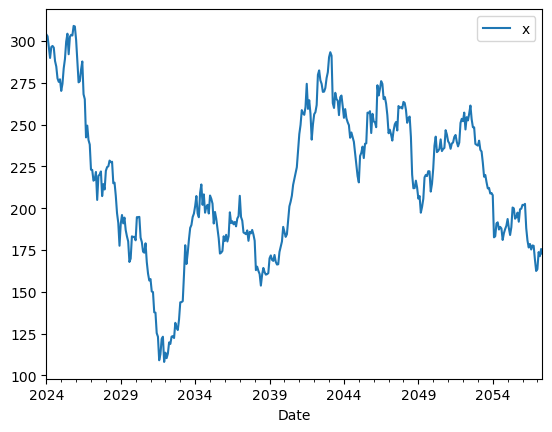

In [494]:
ts6_data.plot()

Spliting the data in train and test

In [512]:
split = int(len(ts6_data) * 0.8)
# Split into train and test sets
ts6_train = ts6_data.iloc[:split]
ts6_test = ts6_data.iloc[split:]

<Axes: xlabel='Date'>

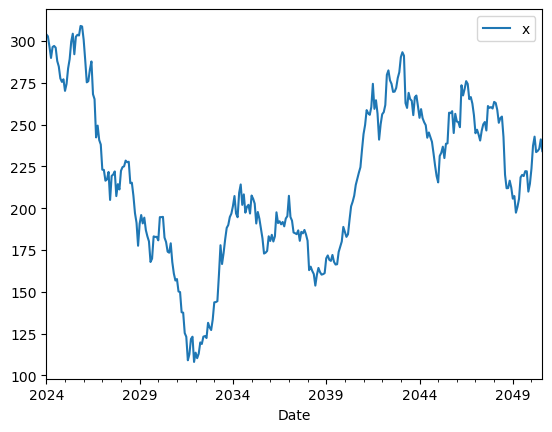

In [514]:
ts6_train.plot()

### Stationarity

The train data don't look to have a pattern, the index its updated for the name time, instead of unnamed. Continue with the test to check stationarity.

In [518]:
print(adfuller(ts6_train["x"]))

(-2.136303369806375, 0.23016952888765313, 4, 315, {'1%': -3.451281394993741, '5%': -2.8707595072926293, '10%': -2.571682118921643}, 2077.4868254478797)


The p-value is the second item in the list, in this case, its0.23016952888765313. Meaning that we fail to reject the H0, and the time series is non-stationary. We need to difference the data.

First difference of the series

In [521]:
FirstDifference = (ts6_train["x"] - ts6_train["x"].shift(1)).dropna()

<Axes: xlabel='Date'>

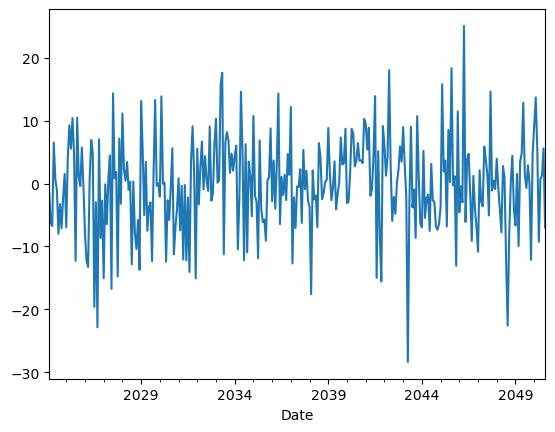

In [523]:
FirstDifference.plot()

In [527]:
round(adfuller(FirstDifference)[1],3)

0.0

the p-value is now less than 0.001, we reject the null hypothesis and conclude that the first differenced series is stationary.

Since the first difference of the series is stationary, ___d = 1___.

Creating a plot to see the autocorrelation function and partial autocorrelation function plots to try to determine the orders of p and q, the autoregressive and moving average terms.

## ACF Plot

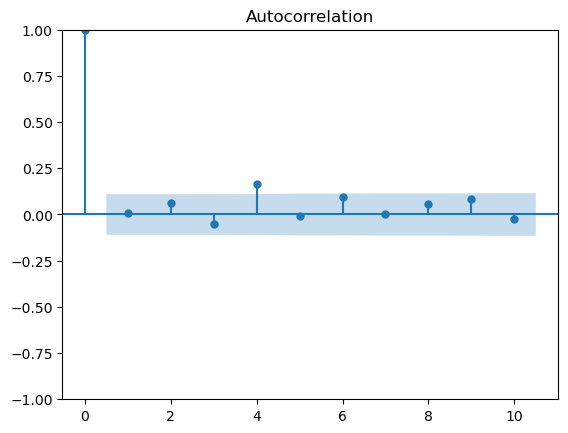

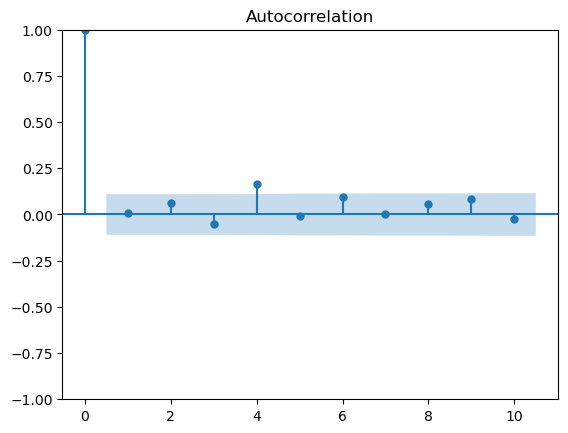

In [533]:
plot_acf(FirstDifference, lags=10)

The lag 0 represents the __autocorrelation__ of the series with itself, which is always 1. There is only one significant spike at lag 1, so ___q=1___.

## PACF Plot

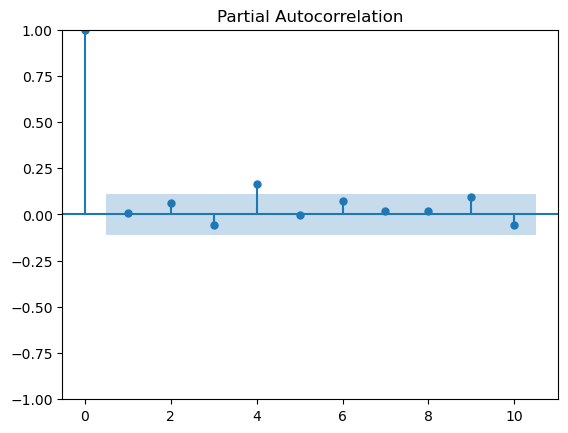

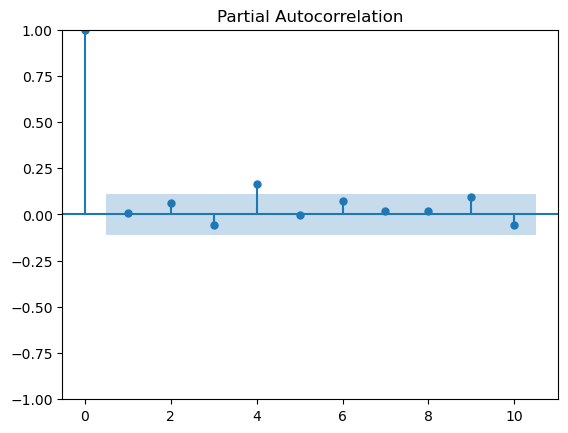

In [537]:
plot_pacf(FirstDifference, lags=10)

The number of significant spikes in the pacf plot indicate the ___p___. In this case is 1, so, ___p=1___.

## Fitting the models

### ARIMA(1,1,1)

In [541]:
model111 = ARIMA(ts6_train["x"], order=(1,1,1))
fit111 = model111.fit()
print(fit111.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  320
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1094.755
Date:                Mon, 02 Dec 2024   AIC                           2195.510
Time:                        09:43:55   BIC                           2206.806
Sample:                    01-01-2024   HQIC                          2200.021
                         - 08-01-2050                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8617      0.168     -5.116      0.000      -1.192      -0.532
ma.L1          0.8117      0.196      4.151      0.000       0.428       1.195
sigma2        56.0197      3.880     14.437      0.0

Lets try the auto_arima() function to automatically determine the model order.

In [598]:
auto_arima(ts6_train["x"])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

The auto_arima() function suggested ARIMA(0,1,0) as the most suitable model.

In [603]:
model010 = ARIMA(ts6_train["x"], order=(0,1,0))
fit010 = model010.fit()
print(fit010.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  320
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1096.304
Date:                Mon, 02 Dec 2024   AIC                           2194.609
Time:                        10:18:52   BIC                           2198.374
Sample:                    01-01-2024   HQIC                          2196.112
                         - 08-01-2050                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        56.5714      3.789     14.932      0.000      49.146      63.997
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                10.06
Prob(Q):                              0.90   Pr

## Diagnostics

<Axes: xlabel='Date'>

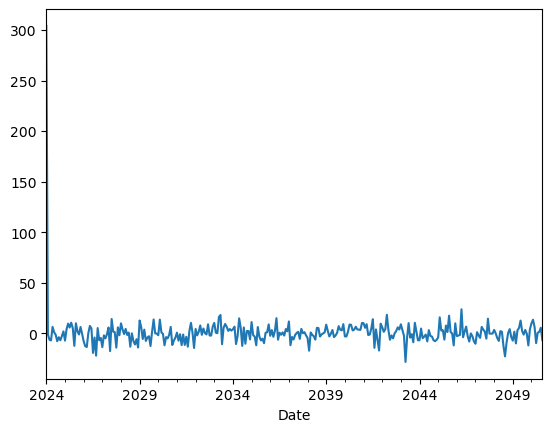

In [551]:
fit111.resid.plot()

The residuals appear to be close to white noise.

Checking for correlation in the residuals

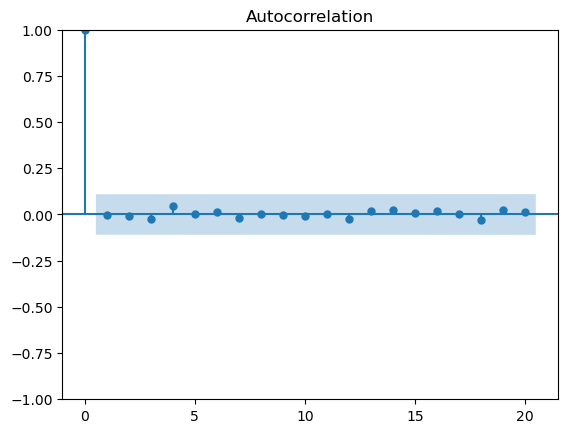

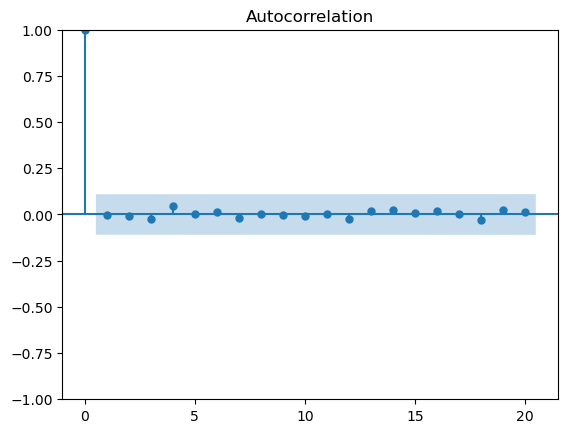

In [606]:
residuals1 = fit010.resid
plot_acf(residuals1, lags=20)

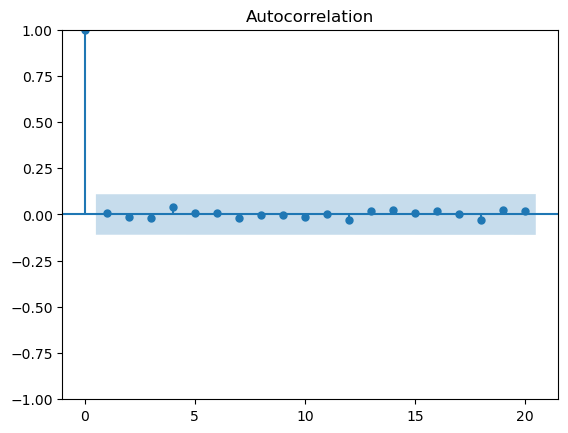

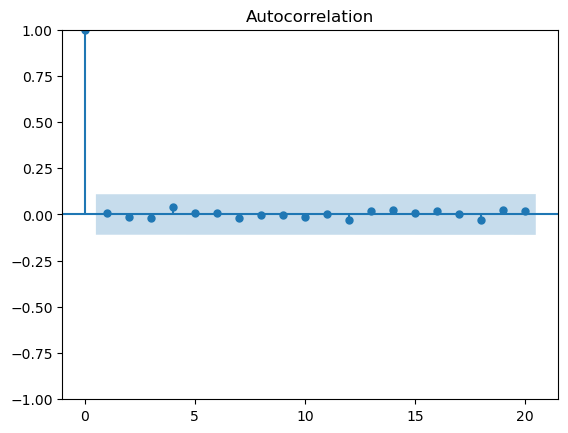

In [567]:
residuals = fit111.resid
plot_acf(residuals, lags=20)

In [571]:
acorr_ljungbox(fit111.resid, lags=10)

,lb_stat,lb_pvalue
1,0.024403,0.875865
2,0.092405,0.954849
3,0.226050,0.973278
4,0.746475,0.945476
5,0.769071,0.978964
6,0.790207,0.992334
7,0.883825,0.996491
8,0.887755,0.998863
9,0.888379,0.999655
10,0.941679,0.999869


In [608]:
acorr_ljungbox(fit010.resid, lags=10)

,lb_stat,lb_pvalue
1,0.000665,0.979424
2,0.012674,0.993683
3,0.246253,0.969798
4,0.923879,0.921110
5,0.924423,0.968428
6,0.978591,0.986411
7,1.129039,0.992470
8,1.129148,0.997293
9,1.138007,0.999048
10,1.165736,0.999654


The residuals are uncorrelated (white noise). The p-value for all the lags (1 to 10) are greater than 0.05

## Evaluation

Producing a forecast using the fit model. 81 periods into the future (the length of the test series).

In [610]:
predictions_111 = fit111.forecast(len(ts6_test))
predictions_010 = fit010.forecast(len(ts6_test))

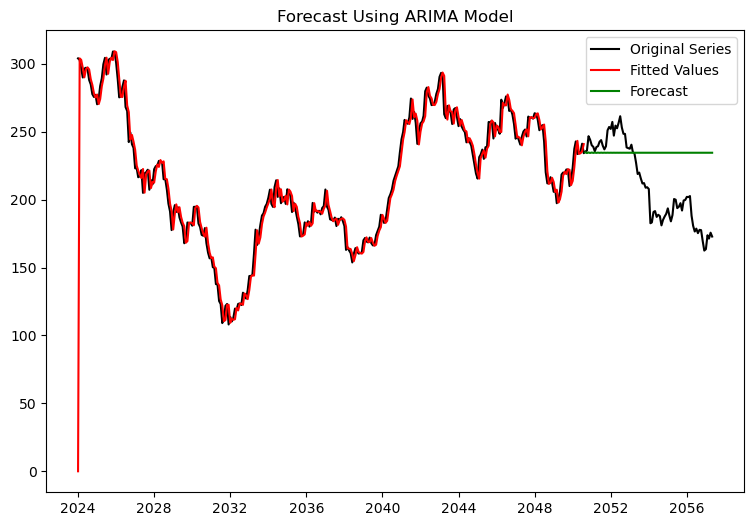

In [612]:
plt.figure(figsize=(9, 6))
plt.plot(ts6_data["x"], color= "black", label="Original Series")
plt.plot(fit111.fittedvalues,color="red",label="Fitted Values")
plt.plot(predictions_111, color= "green", label="Forecast")
plt.legend()
plt.title("Forecast Using ARIMA Model")
plt.show()

## mae

In [620]:
mae111 = mean_absolute_error(
    ts6_train,
    fit111.fittedvalues
)
rmse111 = mean_squared_error(
    ts6_train,
    fit111.fittedvalues) **0.5
mape111 = mean_absolute_percentage_error(
    ts6_train,
    fit111.fittedvalues)
print("ARIMA(1,1,1) - MAE:{:.3F}, RMSE:{:.3F}, MAPE:{:.3F}".format(mae111,rmse111,mape111))

ARIMA(1,1,1) - MAE:6.656, RMSE:18.564, MAPE:0.031


Mean Absolute Error (MAE) - 6.656 its a relative low error, the model fit closely in the training data.
Root Mean Squared Error (RMSE) - 18.564 reflects a reasonable fit the training data, even that its higher than the MAE.
Mean Absolute Percentage Error (MAPE) - 0.031 indicate that the model's predictions are highly accurate.